In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import chardet
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('/Users/nandinisridharr/Documents/Lending Club - Case Study/loan.csv', 'rb') as raw:
    res = chardet.detect(raw.read(39717))
print(res)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [3]:
l = pd.read_csv('/Users/nandinisridharr/Documents/Lending Club - Case Study/loan.csv',engine='python')

### Data Exploration and Cleaning

In [4]:
l.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [5]:
assert len(l[l.duplicated('member_id',keep=False)])+len(l[l.duplicated('id',keep=False)])==0, 'There are duplicate rows.'

<h3>Dropping rows:</h3> <br>
- Since we only want to know whether the borrower will default or not, rows with loan_status = Current are of no use and are hence being removed.

In [6]:
l=l[l['loan_status']!='Current'].reset_index(drop=True)

<h3>Dropping columns:</h3> <br>
1. We check if there are any columns containing only NULL values, and if there are, they will be dropped.

In [7]:
null_cols = [i for i in l.columns if l[i].notnull().sum()==0]

In [8]:
l=l.drop(null_cols,axis=1)

2. We drop columns that contain more than 60% NULL values as these cannot be imputed accurately.

In [9]:
l=l.drop([i for i in l.columns if l[i].isnull().sum()/len(l)>=0.6],axis=1)

3. We also check if there are any columns containing the same value for all the rows as these columns will not give any insights and therefore need to be dropped. Since all rows have the same value, this variable will have the same influence over different categories of the dependent variable.

In [10]:
single_valued_cols = [i for i in l.columns if len(l[i].unique())==1]
single_valued_cols

['pymnt_plan',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'delinq_amnt']

In [11]:
l=l.drop(single_valued_cols,axis=1)

4. For columns containing only two unique values where one of them is NaN, we cannot impute the column as it would become a single valued column, and we cannot analyse it if it has only 0 and NaN.

In [12]:
l=l.drop([i for i in l.columns if (len(l[i].unique())==2)&(l[i].nunique()==1)],axis=1)

5. Dropping columns based on domain knowledge: 
- id, member_id: Will not impact the dependent variable as they are the same as borrower name. 
- title, desc: A categorised version of these columns has already been given (purpose) which is sufficient for analysis and therefore these are now unnecessary. Also, these columns cannot be aggregated/categorised separately.
- emp_title: There are too many vague categories in this column leading to an uneccesarily complicated analysis.
- url: Cannot analyse this column and it will not have any impact on the dep. variable.
- zip_code: Last two digits have been replaced by 'x', so area cannot be determined properly.
- recoveries, collection_rec_fee, total_rec_late_fee: Since these are post charge-off, we are dropping these columns. 

In [13]:
l=l.drop(['id','member_id','title','desc','emp_title','url','zip_code','recoveries','collection_recovery_fee','total_rec_late_fee'],axis=1)

In [14]:
#Getting rid of extra spaces. This var. is not being converted to numerical type and it has only two values and can be treated as categorical.
l['term']=l['term'].str.strip()

In [15]:
#Removing % sign and converting to ratio from percentage for analysis
l['int_rate']=l['int_rate'].str.replace('%','').astype(float)
l['int_rate']=l['int_rate']/100

In [16]:
#Removing % sign and converting to ratio from percentage for analysis
l['revol_util']=l['revol_util'].str.replace('%','').astype(float)
l['revol_util']=l['revol_util']/100

# Imputing with median value
l['revol_util']=l['revol_util'].fillna(l['revol_util'].median())

In [17]:
#Assigning number to each category of the dep. variable loan_status to get correlation.
l['loan_status_num']=np.where(l['loan_status']=='Charged Off',1,0)

In [18]:
l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38577 entries, 0 to 38576
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   funded_amnt           38577 non-null  int64  
 2   funded_amnt_inv       38577 non-null  float64
 3   term                  38577 non-null  object 
 4   int_rate              38577 non-null  float64
 5   installment           38577 non-null  float64
 6   grade                 38577 non-null  object 
 7   sub_grade             38577 non-null  object 
 8   emp_length            37544 non-null  object 
 9   home_ownership        38577 non-null  object 
 10  annual_inc            38577 non-null  float64
 11  verification_status   38577 non-null  object 
 12  issue_d               38577 non-null  object 
 13  loan_status           38577 non-null  object 
 14  purpose               38577 non-null  object 
 15  addr_state         

## Class Imbalance:

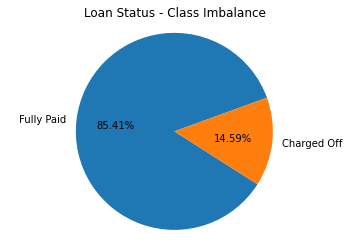

In [19]:
labels= list(l['loan_status'].value_counts().index)
sizes= list(l['loan_status'].value_counts().values)
plt.pie(sizes,labels=labels, startangle = 20, autopct='%1.2f%%')
plt.axis('equal')
plt.title('Loan Status - Class Imbalance')
plt.show()

- The pie chart shows that the number of borrowers who have Fully Paid loan status is much higher than the number of borrowers who have Charged Off loan_status.

### Correlation

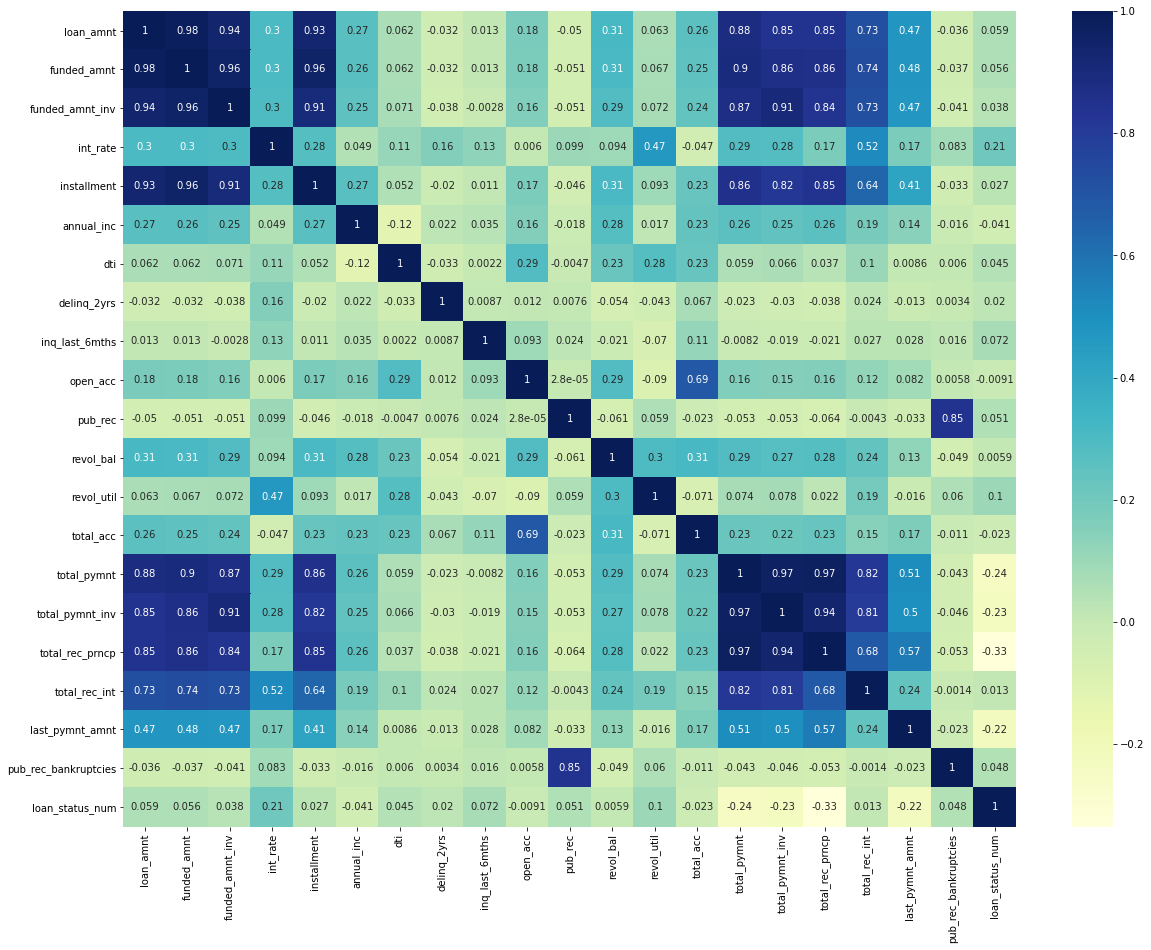

In [20]:
#Checking correlation between numerical type variables:
plt.figure(figsize=(20,15))
sns.heatmap(l.corr(), annot=True, cmap="YlGnBu")
plt.show()

## Defining Required Functions:

### Plotting bar plots:

In [21]:
def barPlot(col,col_type,df=l):
    if col_type=='Nominal Categorical':
        df['Count']=1
        df1=pd.pivot_table(data=df,index=col,columns='loan_status',values='Count',aggfunc='sum')
        df=df.drop('Count',axis=1)
        df1.plot(kind='bar',stacked=True)
    elif col_type=='Continuous':
        x=pd.DataFrame([np.quantile(df[col],i) for i in np.arange(0.05,1,0.05)],columns=['Quantile'])
        x['Fully Paid']=[len(df.loc[(df[col]<=i)&(df['loan_status']=='Fully Paid'),'loan_status']) for i in x['Quantile']]
        x['Charged Off']=[len(df.loc[(df[col]<=i)&(df['loan_status']=='Charged Off'),'loan_status']) for i in x['Quantile']]

        y=pd.DataFrame()
        y[str(col)+'_bins']=[str(int(x.loc[i,'Quantile']))+'-'+str(int(x.loc[i+1,'Quantile'])) for i in range(0,len(x)-1)]
        y['Fully Paid']=[x.loc[i+1,'Fully Paid']-x.loc[i,'Fully Paid'] for i in range(0,len(x)-1)]
        y['Charged Off']=[x.loc[i+1,'Charged Off']-x.loc[i,'Charged Off'] for i in range(0,len(x)-1)]
        y['Default Rate']=y['Charged Off']/(y['Charged Off']+y['Fully Paid'])
        y.index=y[str(col)+'_bins']
        y=y[['Default Rate']]
        y.plot.bar()
    else:
        x=pd.DataFrame(df[col].unique(),columns=[str(col)])
        x['Fully Paid']=[len(df.loc[(df[col]==i)&(df['loan_status']=='Fully Paid'),'loan_status']) for i in df[col].unique()]
        x['Charged Off']=[len(df.loc[(df[col]==i)&(df['loan_status']=='Charged Off'),'loan_status']) for i in df[col].unique()]
        x['Default Rate']=x['Charged Off']/(x['Charged Off']+x['Fully Paid'])
        x=x.sort_values(by=col,ascending=True)
        x.index=x[str(col)]
        x=x[['Default Rate']]
        x.plot.bar()
plt.show()

barPlot: Function to plot barplots w.r.t the dependent variable (loan_status) given a variable and it's type (segmented analysis). <br>
- If the variable is of nominal categorical type, we create a stacked bar chart (we see the number of fully paid and charged off values that fall in each category). 
- For categorical data, we create a dataframe containing the categories and get the default rate (no. of charged off values/total values in that category) for each category. 
- For continuous vairables, we follow a similar process by converting it to a categorical variable (by binning based on quantiles ranging from 5%-95%) and then getting the default rate for each bin.

<b>Note:</b> Due to the class imbalance of the dependant variable, it is preferred to consider default rate rather than number of defaulters in each category as default rate shows the proportion which would result in a more accurate analysis. This method has been followed to handle class imbalance instead of dropping data to equalize as that would result in a huge loss of data which could lead to incorrect analyses.

### Date columns

In [22]:
def dateCol(date_col,col_type,df=l,dep='loan_status',form='%b-%y'):
    df2=df[df[date_col].notnull()].reset_index(drop=True)
    df2[str(date_col)+'_year']=pd.to_datetime(df2[date_col],format=form).dt.year
    barPlot(str(date_col)+'_year',col_type,df2)

dateCol: We are converting the date columns to year and analysing loan_status year-wise.

## Data Analysis

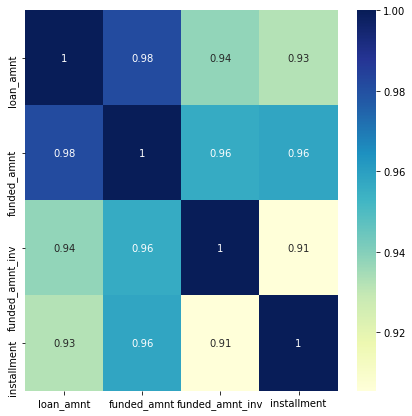

In [23]:
plt.subplots(figsize=(7,7))
sns.heatmap(l[['loan_amnt','funded_amnt','funded_amnt_inv','installment']].corr(), annot=True, cmap="YlGnBu")
plt.show()

- Based on business knowledge, the variables loan_amnt, funded_amnt, funded_amnt_inv and installment should be direclty proportional. This can be seen in the heatmap.
- Since the correlation between each is more than 90% and is positive, each of these variables should have the same impact on the loan_status column. So it is enough to check one of these. 

### funded_amnt

In [24]:
#Summary statistics 
l['funded_amnt'].describe()

count    38577.000000
mean     10784.058506
std       7090.306027
min        500.000000
25%       5200.000000
50%       9550.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

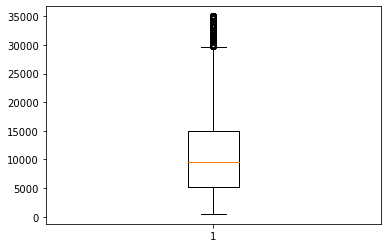

In [25]:
plt.boxplot(l['funded_amnt'])
plt.show()

As shown from both, the summary metrics and the boxplot, the funded_amnt has outliers and therefore median is a better representative value when doing segmented analysis.

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


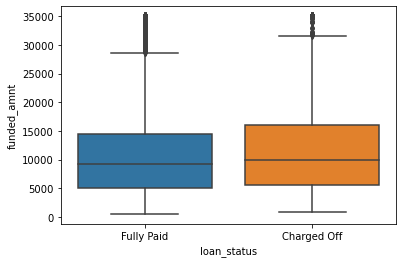

In [26]:
sns.boxplot(l['loan_status'],l['funded_amnt'])
plt.show()

In [27]:
l[['funded_amnt','loan_status_num']].corr()

,funded_amnt,loan_status_num
funded_amnt,1.000000,0.056497
loan_status_num,0.056497,1.000000


- As shown by the barplot and boxplot, median funded amount does not change much across the categories of loan_status implying that funded_amnt does not affect loan_status much. This fact is reinforced by the correlation matrix which shows they have a correlation of 6% approx. which suggests that funded_amnt has little positive impact on loan_status.

### Term

In [28]:
l['term'].value_counts()

36 months    29096
60 months     9481
Name: term, dtype: int64

In [29]:
pd.crosstab(pd.Categorical(l['loan_status']),pd.Categorical(l['term']))

col_0,36 months,60 months
row_0,,
Charged Off,3227,2400
Fully Paid,25869,7081


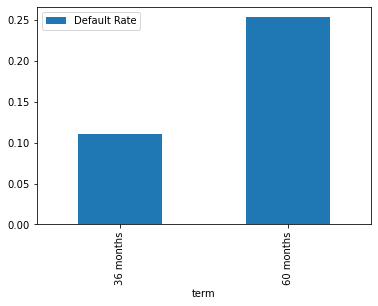

In [30]:
barPlot('term', 'Categorical')

- As shown by the barplot, the default rate is comparably higher when the term is 60 months rather than 36 months.
- This could be due to the fact that over a longer period of time, the borrowers' income may dwindle, leading to a higher default rate.

### int_rate

In [31]:
l['int_rate'].describe()

count    38577.000000
mean         0.119322
std          0.036913
min          0.054200
25%          0.089400
50%          0.117100
75%          0.143800
max          0.244000
Name: int_rate, dtype: float64

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


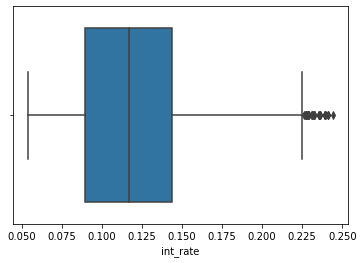

In [32]:
sns.boxplot(l['int_rate'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


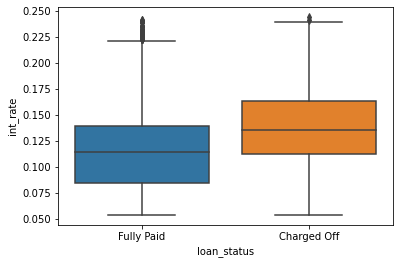

In [33]:
sns.boxplot(l['loan_status'],l['int_rate'])
plt.show()

In [34]:
l[['loan_status_num','int_rate']].corr()

,loan_status_num,int_rate
loan_status_num,1.00000,0.21139
int_rate,0.21139,1.00000


As seen in the boxplot, the number of defaulters increases as interest rate increases. The correlation matrix also shows that they have slight positive correlation.

### annual_inc

In [35]:
l['annual_inc'].describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


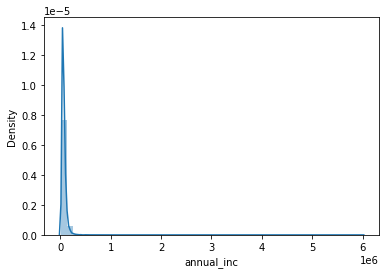

In [36]:
sns.distplot(l['annual_inc'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


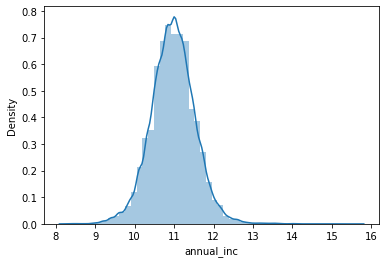

In [37]:
sns.distplot(np.log(l['annual_inc']))
plt.show()

The data is no longer skewed. Thus we create a log variable and continue our analysis on the same.

In [38]:
l['annual_inc_log']=np.log(l['annual_inc'])

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


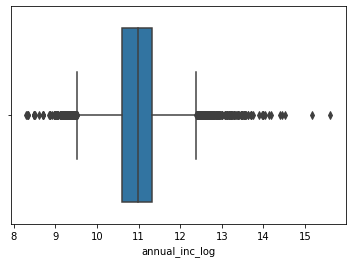

In [39]:
sns.boxplot(l['annual_inc_log'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


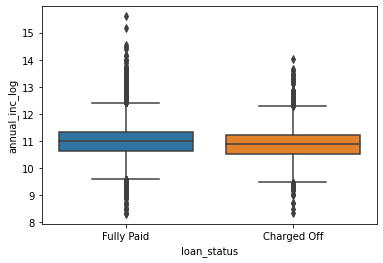

In [40]:
sns.boxplot(l['loan_status'],l['annual_inc_log'])
plt.show()

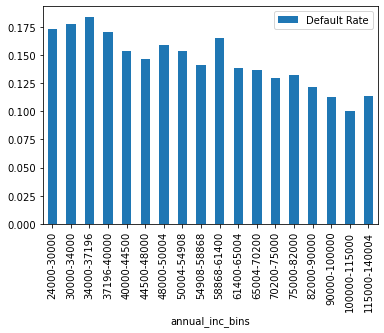

In [41]:
barPlot('annual_inc','Continuous')

In [42]:
l[['annual_inc_log','loan_status_num']].corr()

,annual_inc_log,loan_status_num
annual_inc_log,1.000000,-0.069083
loan_status_num,-0.069083,1.000000


- The boxplots show that across the loan_status categories, there is not much difference in the median for each category. This indicates that annual_inc does not influence the loan_status variable much.
- The correlation matrix shows that it has a negative correlation of 4% with loan_status indicating that it does not influence loan_status much.

### dti

In [43]:
l['dti'].describe()

count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.130000
50%         13.370000
75%         18.560000
max         29.990000
Name: dti, dtype: float64

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


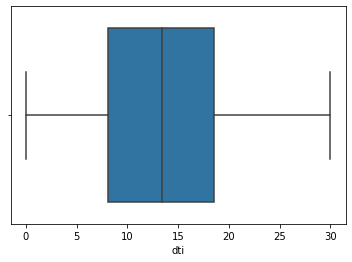

In [44]:
sns.boxplot(l['dti'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


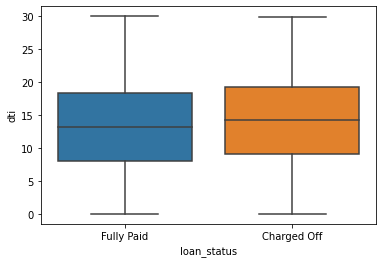

In [45]:
sns.boxplot(l['loan_status'],l['dti'])
plt.show()

In [46]:
l[['loan_status_num','dti']].corr()

,loan_status_num,dti
loan_status_num,1.000000,0.045078
dti,0.045078,1.000000


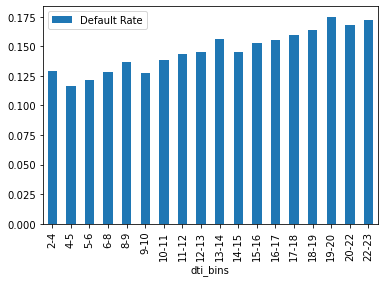

In [47]:
barPlot('dti','Continuous')

- As DTI increases, the default also increases. DTI is debt-to-income ration, so as the debt increases or income decreases the chances of defaulting is more, resulting in this trend.
- Although there is an inverse relationship between dti and loan_status, the correlation is only 4% indicating there is only a small influence. This can also be seen in the boxplot which shows a very small difference in median across loan_status categories.

### Grade

In [48]:
l['grade'].value_counts()

B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: grade, dtype: int64

In [49]:
pd.crosstab(pd.Categorical(l['loan_status']),pd.Categorical(l['grade']))

col_0,A,B,C,D,E,F,G
row_0,,,,,,,
Charged Off,602,1425,1347,1118,715,319,101
Fully Paid,9443,10250,6487,3967,1948,657,198


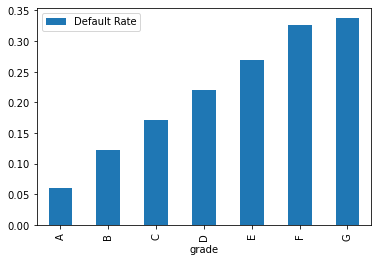

In [50]:
barPlot('grade','Categorical')

- As seen in the bar plot, there is an increase in default rate from A to G (approx. 30% increase). 
- Since A is the grade with least risk and G is maximum risk, it can be seen that the default rate increases with an increase in risk.

### sub-grade

In [51]:
sg=pd.DataFrame(l['sub_grade'].unique(),columns=['sub_grade'])
sg=sg.sort_values('sub_grade').reset_index(drop=True)
sg['subGrade_num']=[i+1 for i in sg.index]
l=pd.merge(l,sg,on='sub_grade',how='left')

In [52]:
sg

,sub_grade,subGrade_num
0,A1,1
1,A2,2
2,A3,3
3,A4,4
4,A5,5
5,B1,6
6,B2,7
7,B3,8
8,B4,9
9,B5,10


<b>Note:</b> sub_grade has been converted to numerical categorical type where A1 (least risk) is given value 1, A2 value 2 and so on till G5 (max. risk) which has value 35, as shown in the table above.

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


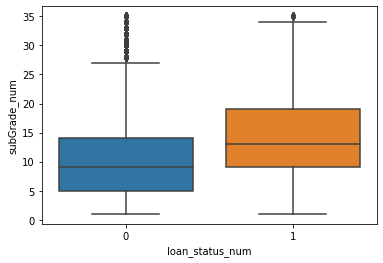

In [53]:
sns.boxplot(l['loan_status_num'],l['subGrade_num'])
plt.show()

In [54]:
l.loc[l['subGrade_num']==14,'sub_grade'].unique()

array(['C4'], dtype=object)

In [55]:
l[['loan_status_num','subGrade_num']].corr()

,loan_status_num,subGrade_num
loan_status_num,1.00000,0.20532
subGrade_num,0.20532,1.00000


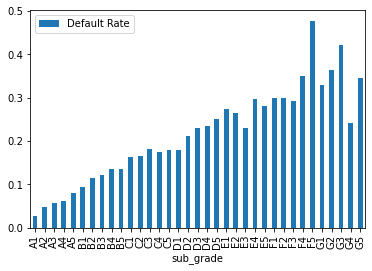

In [56]:
barPlot('sub_grade','Categorical')

- As seen from the boxplot, the median value is higher for Charged Off (C4) than median of Fully Paid (B4) indicating that people with higher (riskier) sub-grades have higher chances of defaulting.
- The same can be seen in the bar plot, i.e., as we approach the riskier sub-grades (D1-G5), the default rate increases (approx. 40% increase).

### emp_length

In [57]:
l['emp_length'].value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [58]:
l['emp_length'].isnull().sum()/len(l)

0.026777613603960908

In [59]:
#Since there are only 2% NULL values, we can drop them for the analysis without worrying about data loss.
l1=l[l['emp_length'].notnull()].reset_index(drop=True)

In [60]:
#Converting to numerical categorical type to make analysis easier
l1['emp_length_cat']=l1['emp_length'].str.replace(' years','')
l1['emp_length_cat']=l1['emp_length_cat'].str.replace(' year','')
l1['emp_length_cat']=l1['emp_length_cat'].str.replace('< 1','0.5')
l1['emp_length_cat']=l1['emp_length_cat'].str.replace('+','')
l1['emp_length_cat']=l1['emp_length_cat'].str.strip()
l1['emp_length_cat']=l1['emp_length_cat'].astype(float)

<ipython-input-60-3f0127ab0b64>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  l1['emp_length_cat']=l1['emp_length_cat'].str.replace('+','')


In [61]:
pd.crosstab(pd.Categorical(l1['loan_status']),pd.Categorical(l1['emp_length_cat']))

col_0,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
row_0,,,,,,,,,,,
Charged Off,639,456,567,555,462,458,307,263,203,158,1331
Fully Paid,3869,2713,3724,3457,2880,2736,1861,1448,1232,1068,7157


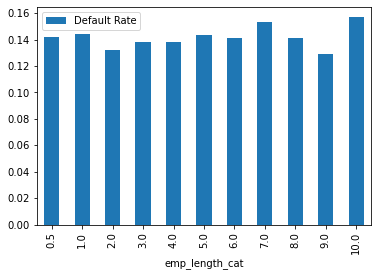

In [62]:
barPlot('emp_length_cat','Categorical',df=l1)

In [63]:
l1[['emp_length_cat','loan_status_num']].corr()

,emp_length_cat,loan_status_num
emp_length_cat,1.000000,0.016399
loan_status_num,0.016399,1.000000


- As seen in the barplot, the default rate does not seem to have an increasing/decreasing trend w.r.t employment length. 
- The same can be seen in the correlation matrix, which shows that they have a correlation of around 1.6% only.

### home_ownership

In [64]:
l['home_ownership'].value_counts()

RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

In [65]:
pd.crosstab(pd.Categorical(l['loan_status']),pd.Categorical(l['home_ownership']))

col_0,MORTGAGE,NONE,OTHER,OWN,RENT
row_0,,,,,
Charged Off,2327,0,18,443,2839
Fully Paid,14694,3,80,2532,15641


In [66]:
#The total values in None category is quite small (only 3 and 0 in Charged Off category) and hence we are not considering this for our analysis
ln=l[l['home_ownership']!='NONE'].reset_index(drop=True)

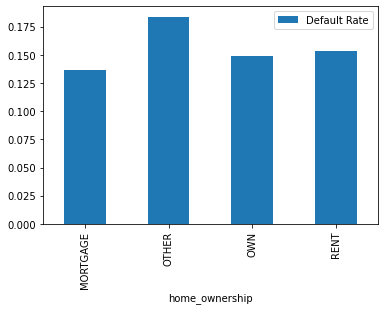

In [67]:
barPlot('home_ownership','Categorical',df=ln)

- As seen in the bar plot, the default rate for categories MORTGAGE, OWN and RENT is almost the same. It is slightly higher for OTHER category but this difference is only around 0.04.
- Thus, we can conclude that since there isn't much change in default rate across categories, home_ownership <b>does not affect</b> loan_status.

### verification_status

In [68]:
l['verification_status'].value_counts()

Not Verified       16694
Verified           12206
Source Verified     9677
Name: verification_status, dtype: int64

In [69]:
pd.crosstab(pd.Categorical(l['loan_status']),pd.Categorical(l['verification_status']))

col_0,Not Verified,Source Verified,Verified
row_0,,,
Charged Off,2142,1434,2051
Fully Paid,14552,8243,10155


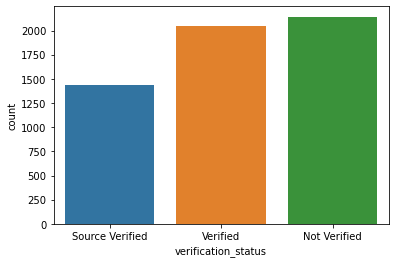

In [70]:
sns.countplot(x='verification_status', data=l[l['loan_status']=='Charged Off'])
plt.show()

In [71]:
l['verification_status_num']=np.where(l['verification_status']=='Not Verified',1,0)

In [72]:
l[['verification_status_num','loan_status_num']].corr()

,verification_status_num,loan_status_num
verification_status_num,1.000000,-0.043439
loan_status_num,-0.043439,1.000000


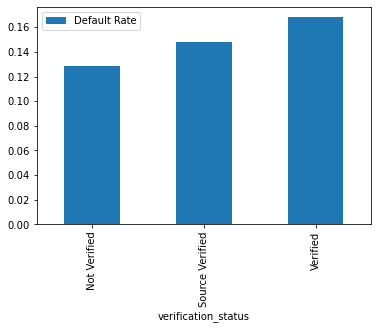

In [73]:
barPlot('verification_status','Categorical')

- Although the barplot shows that the default rate is higher for verified statuses, the correlation matrix shows that verification_status and loan_status are only 4% (approx.) correlated indicating that it <b>does not influence</b> loan_status much.

### purpose

In [74]:
l['purpose'].value_counts()

debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: purpose, dtype: int64

In [75]:
pd.crosstab(pd.Categorical(l['loan_status']),pd.Categorical(l['purpose']))

col_0,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
row_0,,,,,,,,,,,,,,
Charged Off,160,542,2767,56,347,59,222,106,92,633,19,475,53,96
Fully Paid,1339,4485,15288,269,2528,308,1928,575,484,3232,83,1279,322,830


In [76]:
pd.crosstab(pd.Categorical(l.loc[l['purpose'].isin(['small_business','educational','debt_consolidation','renewable_energy']),'loan_status']),pd.Categorical(l.loc[l['purpose'].isin(['small_business','educational','debt_consolidation','renewable_energy']),'purpose']))

col_0,debt_consolidation,educational,renewable_energy,small_business
row_0,,,,
Charged Off,2767,56,19,475
Fully Paid,15288,269,83,1279


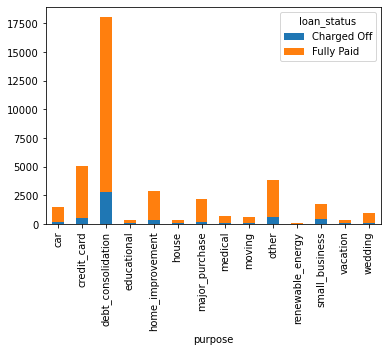

In [77]:
barPlot('purpose','Nominal Categorical')

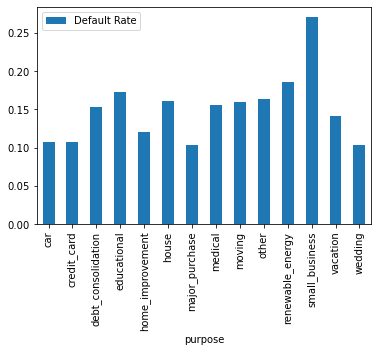

In [78]:
barPlot('purpose','Categorical')

- While maximum number of loans taken are for debt consolidation and credit card purposes, the default rate is highest for small business and educational purposes.
- The default rate for small businesses could be due to an uncertain cash flow leading to charging off.
- For educational, it could be due to an inability to pay off the loan within the decided time period as freshers will likely have lower incomes. 

### pub_rec

In [79]:
l[['pub_rec','pub_rec_bankruptcies']].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.845938
pub_rec_bankruptcies,0.845938,1.000000


- Since the correlation between pub_rec and Pub_rec_bankruptcies is quite high, we will be analysing only pub_rec.
- pub_rec is the number of derogatory records and bankruptcy is a derogatory record, so pub_rec could include pub_rec_bankruptcies.

In [80]:
l['pub_rec'].value_counts()

0    36507
1     2013
2       48
3        7
4        2
Name: pub_rec, dtype: int64

In [81]:
pd.crosstab(pd.Categorical(l['loan_status']),pd.Categorical(l['pub_rec']))

col_0,0,1,2,3,4
row_0,,,,,
Charged Off,5160,457,10,0,0
Fully Paid,31347,1556,38,7,2


In [82]:
#Since the total values for categories 3 and 4 is quite low (7 and 3 respectively), we remove these rows:
l3=l[~l['pub_rec'].isin([3,4])].reset_index(drop=True)

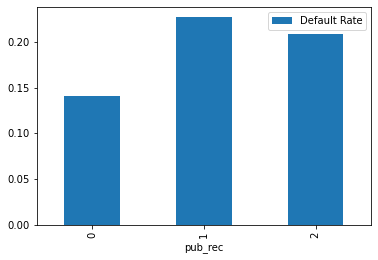

In [83]:
barPlot('pub_rec','Categorical',df=l3)

In [84]:
l1[['pub_rec','loan_status_num']].corr()

,pub_rec,loan_status_num
pub_rec,1.000000,0.049807
loan_status_num,0.049807,1.000000


- The default rate is similar at values 1 and 2 and is only approx. 5% more than the default rate at value 0, indicating that pub_rec <b>does not influence</b> loan_status much.
- The correlation matrix also shows only a correlation of approx. 5% between pub_rec and loan_status.

### total_acc

In [85]:
l['total_acc'].describe()

count    38577.000000
mean        22.052648
std         11.425861
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


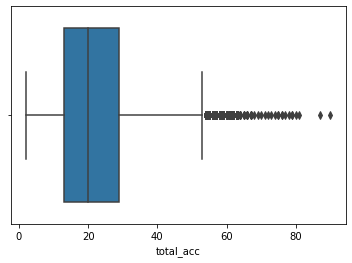

In [86]:
sns.boxplot(l['total_acc'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


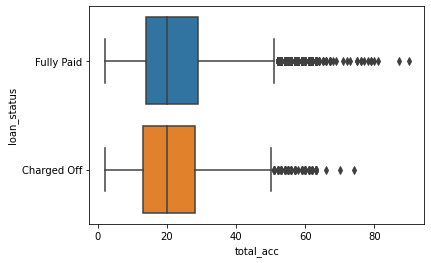

In [87]:
sns.boxplot(l['total_acc'],l['loan_status'])
plt.show()

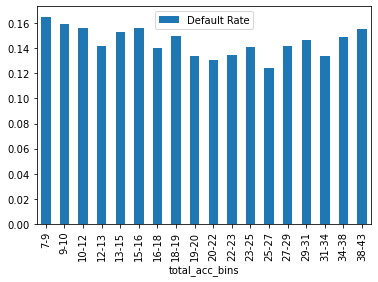

In [88]:
barPlot('total_acc','Continuous')

In [89]:
l[['total_acc','loan_status_num']].corr()

,total_acc,loan_status_num
total_acc,1.000000,-0.022608
loan_status_num,-0.022608,1.000000


- As shown in the boxplot, the median of total_acc is the same across both categories of the dependant variable and thus <b>does not impact</b> the loan_status column much.
- A similar inference can be made by looking at the bar plot which neither shows an increasing nor decreasing default rate trend w.r.t total_acc and a correlation of only -2.2% indicates there is almost no influence of total_acc on loan_status.

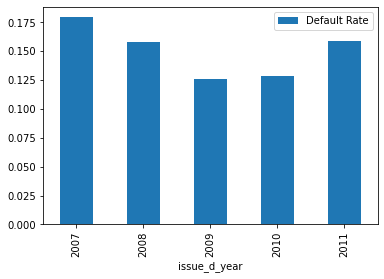

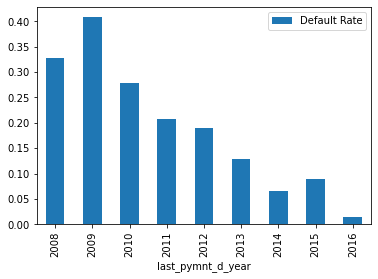

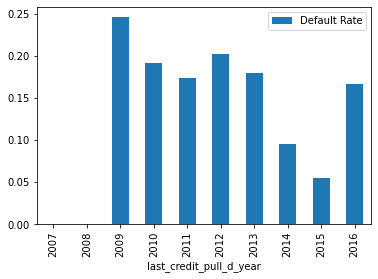

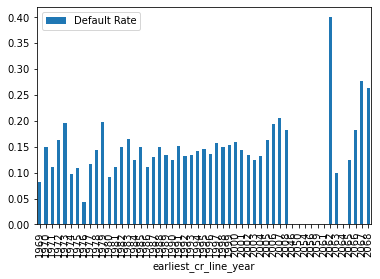

In [90]:
for i in ['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']:
    dateCol(i,'Categorical')

As shown in the bar plot, the default rate is higher in the years 2007,2008 and 2011. This is due to the global economic recession that occurred in 2007-08 and Black Monday that occurred in 2011 in the US.

### delinq_2yrs

In [91]:
l['delinq_2yrs'].value_counts()

0     34386
1      3207
2       673
3       212
4        60
5        21
6        10
7         4
8         2
9         1
11        1
Name: delinq_2yrs, dtype: int64

In [92]:
pd.crosstab(pd.Categorical(l['loan_status']),pd.Categorical(l['delinq_2yrs']))

col_0,0,1,2,3,4,5,6,7,8,9,11
row_0,,,,,,,,,,,
Charged Off,4936,507,130,35,13,3,1,1,1,0,0
Fully Paid,29450,2700,543,177,47,18,9,3,1,1,1


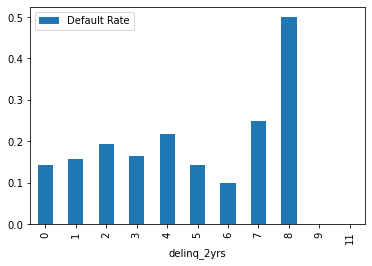

In [93]:
barPlot('delinq_2yrs','Categorical')

In [94]:
l[['delinq_2yrs','loan_status_num']].corr()

,delinq_2yrs,loan_status_num
delinq_2yrs,1.000000,0.020096
loan_status_num,0.020096,1.000000


- As shown, the default rate is higher when the delinq_2yrs is equaL to 4,7 or 8 but dips at values 5 and 6. Thus we cannot conclude that delinq_2yrs has much influence on the loan_status column.
- This is also shown by the correlation of 2%.

### inq_last_6mths

In [95]:
l['inq_last_6mths'].value_counts()

0    18709
1    10660
2     5654
3     2983
4      316
5      144
6       63
7       34
8       14
Name: inq_last_6mths, dtype: int64

In [96]:
pd.crosstab(pd.Categorical(l['loan_status']),pd.Categorical(l['inq_last_6mths']))

col_0,0,1,2,3,4,5,6,7,8
row_0,,,,,,,,,
Charged Off,2280,1677,943,619,51,28,16,10,3
Fully Paid,16429,8983,4711,2364,265,116,47,24,11


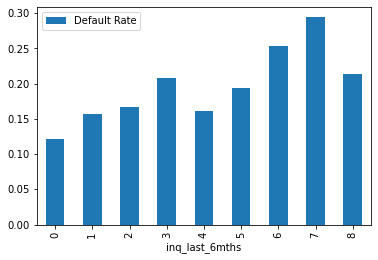

In [97]:
barPlot('inq_last_6mths','Categorical')

In [98]:
l[['inq_last_6mths','loan_status_num']].corr()

,inq_last_6mths,loan_status_num
inq_last_6mths,1.000000,0.071878
loan_status_num,0.071878,1.000000


- There is a slight increase in default rate as number of inquiries increases but the difference at value 0 (min. default rate) and 7 (max. default rate) is only approx. 20%. 
- There is also a sudden dip after 7 which indicates it is not a properly increasing trend.
- The correlation between inq_last_6mths and loan_status is only 7%. All of these indicate that inq_last_6mths <b>does not influence</b> loan_status.

### open_acc

In [99]:
l['open_acc'].unique()

array([ 3,  2, 10,  9,  7,  4, 11, 14, 12, 20,  8,  6, 15, 17,  5, 13, 16,
       30, 21, 18, 19, 27, 23, 34, 25, 22, 24, 26, 32, 28, 29, 33, 31, 39,
       35, 36, 38, 44, 41, 42])

In [100]:
barPlot('open_acc','Categorical',a=10,b=7)

TypeError: barPlot() got an unexpected keyword argument 'a'

In [101]:
l['open_acc'].isnull().sum()

0

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


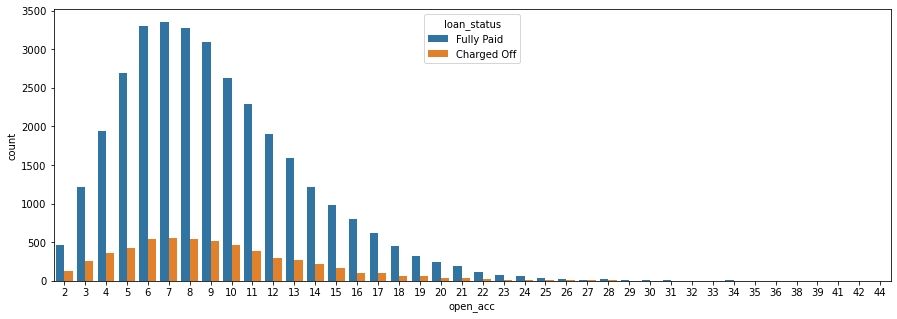

In [102]:
plt.figure(figsize=(15,5))
sns.countplot(l.open_acc, hue='loan_status', data=l)
plt.show()

In [103]:
bins=[0,5,10,15]
labels=["0-5","6-10","11-15"]
l['open_acc_bin']= pd.cut(l['open_acc'], bins=bins, labels=labels)
l['open_acc_bin'].head()


0     0-5
1     0-5
2     0-5
3    6-10
4    6-10
Name: open_acc_bin, dtype: category
Categories (3, object): ['0-5' < '6-10' < '11-15']

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


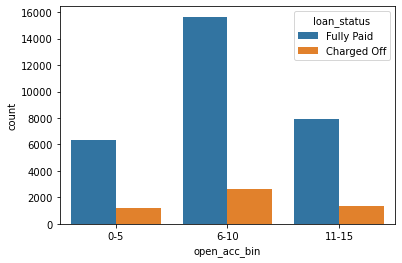

In [104]:

sns.countplot(l.open_acc_bin, hue='loan_status', data=l)
plt.show()


### revol_bal

In [105]:
l['revol_bal'].describe()

count     38577.000000
mean      13289.489826
std       15866.492241
min           0.000000
25%        3650.000000
50%        8762.000000
75%       16912.000000
max      149588.000000
Name: revol_bal, dtype: float64

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


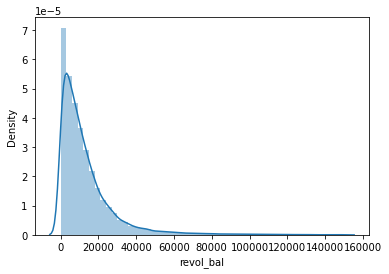

In [106]:
sns.distplot(l['revol_bal'])
plt.show()

As shown in the plot, the revol_bal data has a skewed distribution. To account for this the log values have been considered instead.

In [107]:
#Since we are converting to log, we need to remove 0 values. This will not affect analysis much since only 2.5% are 0 values
l4=l[l['revol_bal']!=0].reset_index(drop=True)
print('Percentage of 0 values in revol_bal column: '+ str(round(((len(l[l['revol_bal']==0])/len(l))*100),2))+'%')

Percentage of 0 values in revol_bal column: 2.52%


In [108]:
l4['revol_bal_log']=np.log(l4['revol_bal'])

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


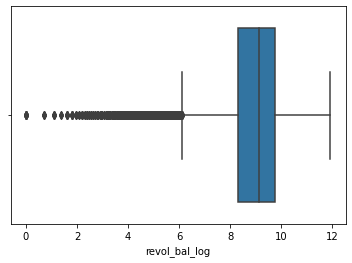

In [109]:
sns.boxplot(l4['revol_bal_log'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


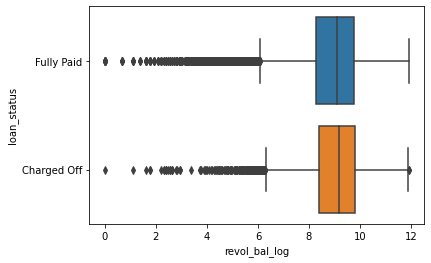

In [110]:
sns.boxplot(l4['revol_bal_log'],l4['loan_status'])
plt.show()

In [111]:
l4[['revol_bal_log','loan_status_num']].corr()

,revol_bal_log,loan_status_num
revol_bal_log,1.000000,0.018647
loan_status_num,0.018647,1.000000


- As seen in the box plot, the median value across loan_status categories is almost the same, indicating that revol_bal <b>does not influence</b> loan_status.
- Also, the correlation between the two is only 1% indicating that this does not influence loan_status.

### revol_util

In [112]:
l['revol_util'].describe()

count    38577.000000
mean         0.487033
std          0.283464
min          0.000000
25%          0.252000
50%          0.491000
75%          0.722000
max          0.999000
Name: revol_util, dtype: float64

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


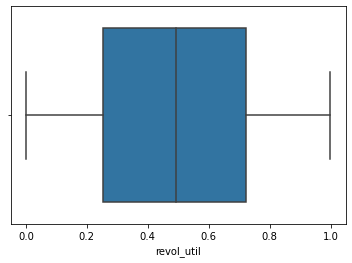

In [113]:
sns.boxplot(l['revol_util'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


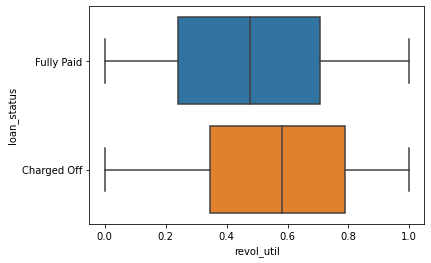

In [114]:
sns.boxplot(l['revol_util'],l['loan_status'])
plt.show()

In [115]:
l['revol_util_groups'] = pd.cut(l['revol_util'], bins=5,precision =0,labels=['0-20','20-40','40-60','60-80','80-100'])

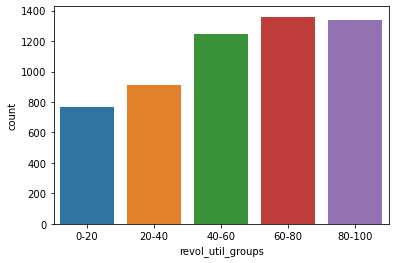

In [116]:
sns.countplot(x='revol_util_groups', data=l[l['loan_status']== 'Charged Off'])
plt.show()

- Both plots show that as revolving utilization rate increases, the default rate also increases. 
- Boxplot shows that Fully Paid has a median value of approx. 40% utilization rate while Charged Off has a median value of approx. 57% utilization rate, indicating that high rates leads to defaulting.
- A high revol_util indicates poor financial planning thus leading to an increased chance of defaulting.

# total_pymnt

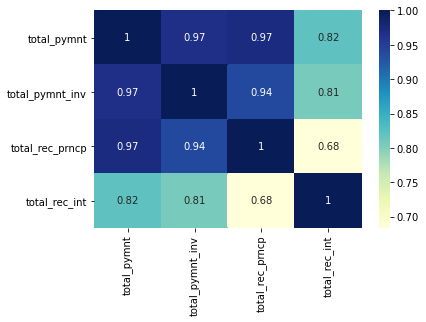

In [117]:
sns.heatmap(l[['total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int']].corr(), annot=True, cmap="YlGnBu")
plt.show()

- The total_rec_prncp and  total_rec_int columns have high correlation with  total_pymnt (the sum oftotal_rec_prncp and  total_rec_int is almost equal to total_pymnt). So the influence of these columns on loan_status will be similar so we are analyzing total_pymnt.
- Similarly total_pymnt_inv and total_pymnt are highly correlated so we will be analyzing only total_pymnt column.

In [118]:
l['total_pymnt'].describe()

count    38577.000000
mean     11866.970365
std       8809.856227
min          0.000000
25%       5513.497338
50%       9674.048405
75%      16136.952430
max      58563.679930
Name: total_pymnt, dtype: float64

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


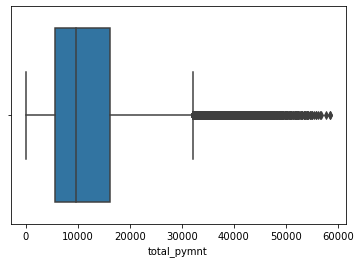

In [119]:
sns.boxplot(l['total_pymnt'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


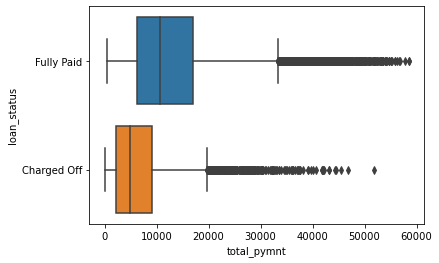

In [120]:
sns.boxplot(l['total_pymnt'],l['loan_status'])
plt.show()

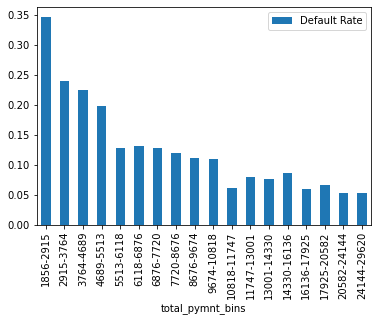

In [121]:
barPlot('total_pymnt','Continuous')

In [122]:
l[['total_pymnt','loan_status_num']].corr()

,total_pymnt,loan_status_num
total_pymnt,1.000000,-0.235898
loan_status_num,-0.235898,1.000000


- As seen in both, the bar plot and box plot, the default rate decreases with an increase in total_pymnt.
- The boxplot shows that for Charged Off the median value is approx. 5000 and for Fully Paid it is 11000 indicating that lower total_pymnt leads to defaulting. 
- If total_pymnt made till date is higher, then the chances of defaulting are lower, leading to the trend seen above.

### last_pymnt_amnt

In [123]:
l['last_pymnt_amnt'].describe()

count    38577.000000
mean      2746.243218
std       4494.648131
min          0.000000
25%        217.420000
50%        568.260000
75%       3447.250000
max      36115.200000
Name: last_pymnt_amnt, dtype: float64

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


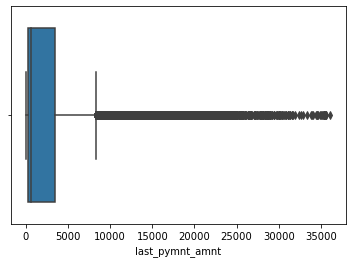

In [124]:
sns.boxplot(l['last_pymnt_amnt'])
plt.show()

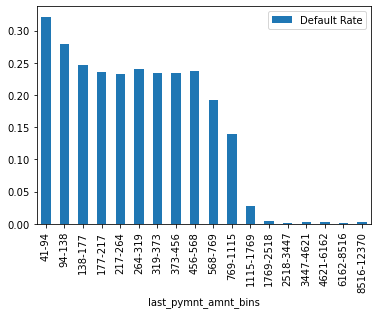

In [125]:
barPlot('last_pymnt_amnt','Continuous')

In [126]:
l[['last_pymnt_amnt','total_pymnt']].corr()

,last_pymnt_amnt,total_pymnt
last_pymnt_amnt,1.000000,0.511535
total_pymnt,0.511535,1.000000


- As per the bar chart, the default rate decreases as the last_pymnt value increases.
- If the final pymnt is very low, then the chances of defaulting are higher.

### open_acc

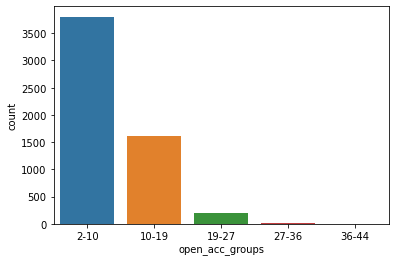

In [127]:
l['open_acc_groups'] = pd.cut(l['open_acc'], bins=5,precision =0,labels=['2-10','10-19','19-27','27-36','36-44'])

sns.countplot(x='open_acc_groups', data=l[l['loan_status']== 'Charged Off'])
plt.show()

In [128]:
l[['open_acc','loan_status_num']].corr()

,open_acc,loan_status_num
open_acc,1.00000,-0.00914
loan_status_num,-0.00914,1.00000


- The default rate seems higher at open_acc values of 33 and 38 but dips between these two (at 34-36). For values 2-30, the default rate is more or less the same. 
- This, along with the correlation matrix indicates that open_acc does not impact lopan_status.

### addr_state

For analysing the state variable, we are considering the top states (states that contain values>1000)

In [129]:
l['addr_state'].value_counts()[l['addr_state'].value_counts()>500]

CA    6949
NY    3698
FL    2781
TX    2659
NJ    1790
IL    1478
PA    1468
VA    1369
GA    1359
MA    1297
OH    1178
MD    1023
AZ     849
WA     818
CO     766
NC     750
CT     726
MI     704
MO     670
MN     605
Name: addr_state, dtype: int64

In [130]:
print('These account for '+str(round((l['addr_state'].value_counts()[l['addr_state'].value_counts()>500].sum()/len(l))*100,2))+'% of the total data.')

These account for 85.38% of the total data.


In [131]:
l5=l[l['addr_state'].isin(list(l['addr_state'].value_counts()[l['addr_state'].value_counts()>500].index))].reset_index(drop=True)

In [132]:
pd.crosstab(pd.Categorical(l5['loan_status']),pd.Categorical(l5['addr_state']))

col_0,AZ,CA,CO,CT,FL,GA,IL,MA,MD,MI,MN,MO,NC,NJ,NY,OH,PA,TX,VA,WA
row_0,,,,,,,,,,,,,,,,,,,,
Charged Off,123,1125,98,94,504,215,197,159,162,103,81,114,114,278,495,155,180,316,177,127
Fully Paid,726,5824,668,632,2277,1144,1281,1138,861,601,524,556,636,1512,3203,1023,1288,2343,1192,691


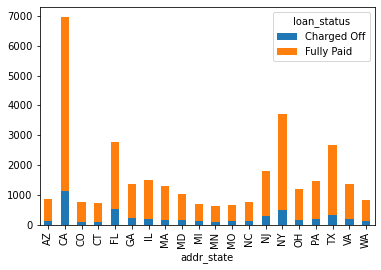

In [133]:
barPlot('addr_state','Nominal Categorical',df=l5)

From this barplot, it can be seen that most borrowers are from California, New York, Florida, Texas and New Jersey. 

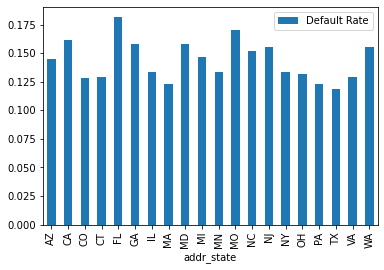

In [134]:
barPlot('addr_state','Categorical',df=l5)

From this plot, it can be seen that the default rate is higher in states: Florida, Missouri, Washington, Maryland, New Jersey and California. It is quite low in states: Texas, Massachusetts, Colorado and Connecticut.

## Multivariate Analysis

1. We check interest rate for Fully Paid and Charged Off status as per the states with highest default rate (Florida and Missouri)

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


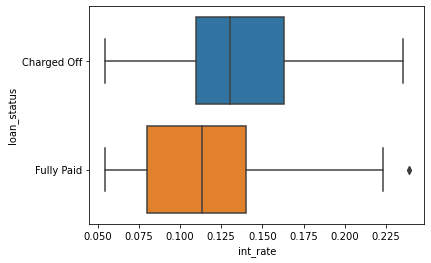

In [135]:
fl=l.loc[l['addr_state']=='FL'].reset_index(drop=True)
mo=l.loc[l['addr_state']=='MO'].reset_index(drop=True)
sns.boxplot(fl['int_rate'],fl['loan_status'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


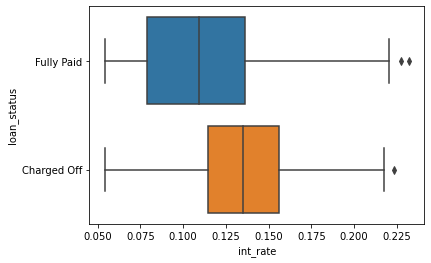

In [136]:
sns.boxplot(mo['int_rate'],mo['loan_status'])
plt.show()

From these plots, we can infer in Florida median interest rate for Charged Off is a bit higher than median interest rate for Fully Paid. It is the same in Missouri where median interest rate for Charged Off is a bit lower than median interest rate for Fully Paid.

2. We check utilization rate for Fully Paid and Charged Off status as per the states with highest default rate (Florida and Missouri)

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


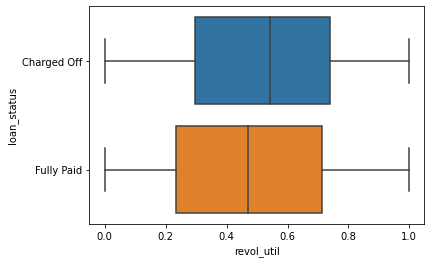

In [137]:
sns.boxplot(fl['revol_util'],fl['loan_status'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


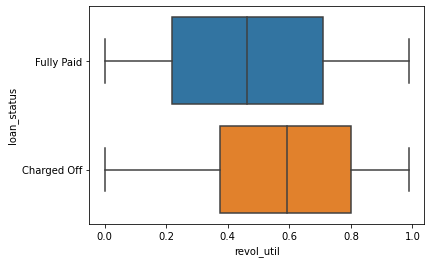

In [138]:
sns.boxplot(mo['revol_util'],mo['loan_status'])
plt.show()

From these plots, we can infer in Florida median utilization rate for Charged Off is a bit higher (0.55) than median utilzation rate for Fully Paid (0.45). It is the same case in Missouri where median utilization rate for Charged Off (0.6) is a higher than median utilization rate for Fully Paid (0.45).

3. We check total payment amount for Fully Paid and Charged Off status as per the states with highest default rate (Florida and Missouri)

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


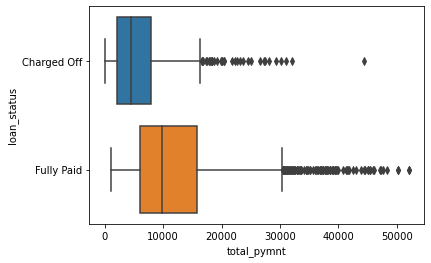

In [139]:
sns.boxplot(fl['total_pymnt'],fl['loan_status'])
plt.show()

/Users/nandinisridharr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


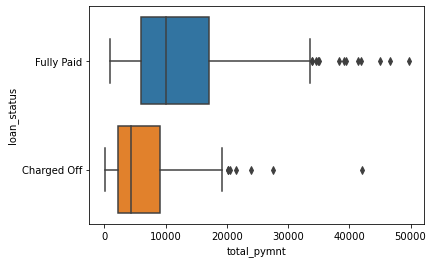

In [140]:
sns.boxplot(mo['total_pymnt'],mo['loan_status'])
plt.show()

From these plots, we can infer in Florida median total payment amount for Charged Off (5000) is a bit lower than median total payment amount for Fully Paid (10,000). It is the same case in Missouri where median total payment amount for Charged Off (4000) is a bit lower than median total payment amount for Fully Paid (10,000).

<h1>Conclusions:</h1> <br>
Based on our analysis, these variables influence the dependent variable:
<ol>
    <li>int_rate</li>
    <li>grade</li>
    <li>sub_grade</li>
    <li>revol_util</li>
    <li>purpose</li>
</ol>